# **Quantum Computing e Qiskit in pillole**
 
***Questo notebook nasce come lezione di laboratorio per i ragazzi delle scuole superiori invitati al Qiskit Fall Fest 2025 al DMI dell'Università di Catania. Data: 19/10/25. Autore: Damiano Trovato***

*Prima di iniziare: esegui la seguenti celle di codice! In questo modo potrai utilizzare la libreria Qiskit, assieme ad una funzione che abbiamo creato appositamente per permettervi di testare velocemente i vostri circuiti!*

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import numpy as np

In [2]:
def run(qc, shots=1024):
    sim_backend = AerSimulator()
    pm = generate_preset_pass_manager(backend=sim_backend)
    isa_qc = pm.run(qc)
    sampler = Sampler(mode=sim_backend)

    job = sampler.run([isa_qc], shots=shots)
    results = job.result()
    counts = results[0].data.c.get_counts()
    return counts

## **Le prime porte logiche**

### Porta NOT (o X)

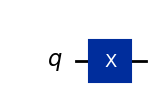

In [3]:
qc = QuantumCircuit(1)
qc.x(0)
qc.draw('mpl')

### NOT controllato, CNOT (o CX)

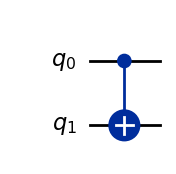

In [4]:
qc = QuantumCircuit(2)
qc.cx(0,1)
qc.draw('mpl')

### SWAP

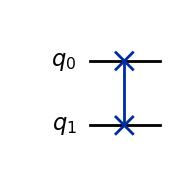

In [5]:
qc = QuantumCircuit(2)
qc.swap(0,1)
qc.draw('mpl')

### Porta di Hadamard (o H)

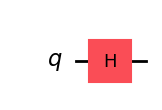

In [6]:
qc = QuantumCircuit(1)
qc.h(0)
qc.draw('mpl')

### Misurazione

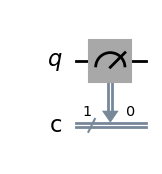

In [7]:
qc = QuantumCircuit(1,1)
qc.measure(0,0)
qc.draw('mpl')

## Esercizio 1: **Quantum Coin**

Nulla, nel mondo dell'informatica classica, è veramente casuale. Sfruttiamo le proprietà della meccanica quantistica, usando il quantum computing come ponte, per creare una "moneta" totalmente casuale.

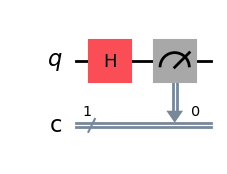

In [8]:
qc = QuantumCircuit(1,1)
qc.h(0)
qc.measure(0,0)
qc.draw('mpl')

Visualizziamo adesso i risultati! Utilizza la funzione definita a inizio file chiamata `run(qc: QuantumCircuit)` per eseguire il circuito, e la funzione `plot_histogram(counts: list)` per mostrare gli esiti.

{'1': 497, '0': 527}


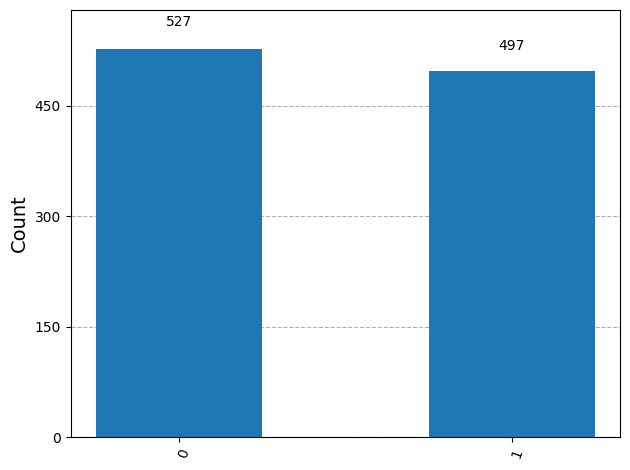

In [9]:
counts = run(qc)
print(counts)
plot_histogram(counts)

## Esercizio 2: **Quantum Random Number**
Facciamo un altro esercizio! Creiamo una funzione che ritorni un circuito quantistico per generare un numero casuale a $n$ cifre.

In [10]:
def rand_number_quantum_circuit(n=1):
    qc = QuantumCircuit(n,n)
    qc.h(range(n))
    qc.measure(range(n),range(n))
    return qc

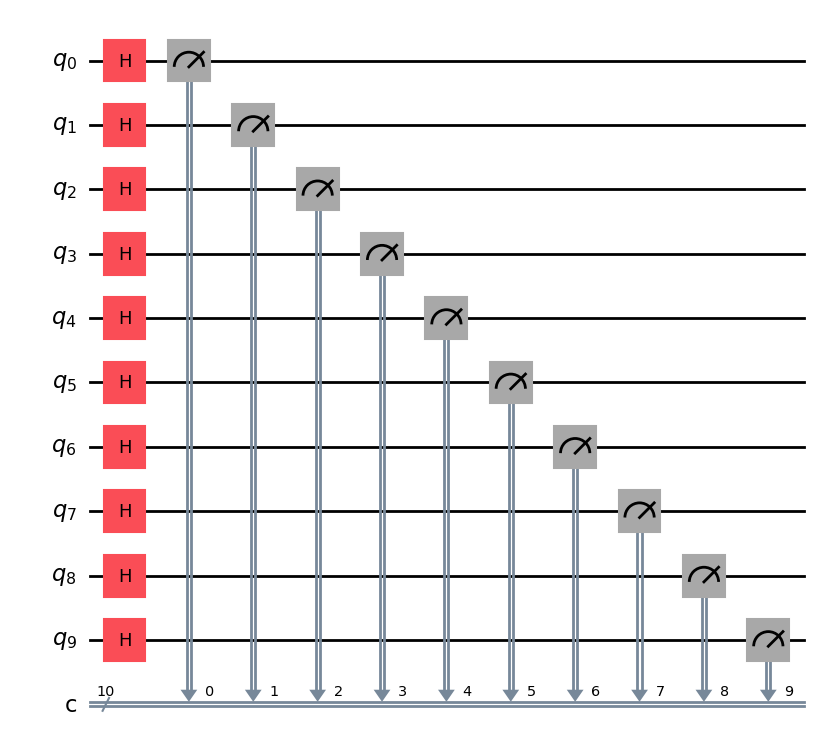

In [11]:
qc = rand_number_quantum_circuit(10)
qc.draw('mpl')

Usa il seguente segmento di codice per convertire la codifica binaria del numero generato in un numero decimale.

In [12]:
result = run(qc, 1)
result = list(list(result)[0])

# algoritmo di conversione da binario a decimale
num = 0
for pos, i in enumerate(result, start=0):
    num += int(i) * 2 ** pos
    pos += 1

print(num)

106


## **E come facciamo a rendere utile la casualità?** - *Algoritmo di Grover*

Il gioco di probabilità è sicuramente uno degli aspetti più affascinanti (o confusionari) della computazione quantistica. L'algoritmo di Grover è un esempio molto interessante di come, tramite un opportuno circuito, si possa manipolare la probabilità dei vari possibili stati misurabili, per ottenere i risultati desiderati. 

### **Il problema della ricerca**
Trovare uno specifico elemento in un insieme di 10 scatole disordinate, significa dover aprire fino a 10 scatole. Con $n$ scatole, $n$ passi. Diremo l'algoritmo di **ricerca lineare** un problema $O(n)$.

L'algoritmo di Grover offre un approccio alternativo alla ricerca, proponendo un algoritmo con complessità $O(\sqrt{n})$.
Un problema di grandezza $n=4$ sarà risolto in $2$, e non $4$ passi. Un problema di grandezza $n=1000000$ sarà risolto solo in $1000$ passi, e non più $1000000$.


[0.5 0.5 0.5 0.5]


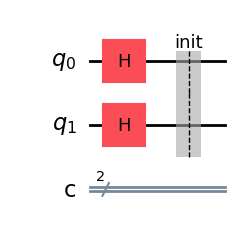

In [13]:
# Inizializza un circuito con 2 qubit e 2 bit classici
qc = QuantumCircuit(2, 2)

# 1. Sovrapposizione: Hadamard su entrambi i qubit
qc.h(range(2))
qc.barrier(label='init')

state = Statevector.from_instruction(qc)
print(np.real(state))
qc.draw('mpl')

[ 0.5  0.5 -0.5  0.5]


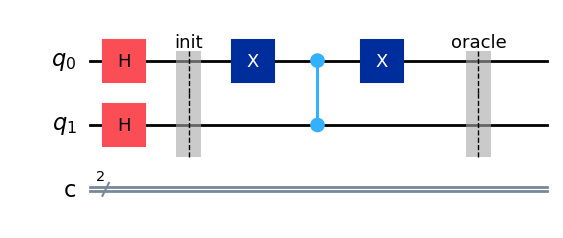

In [14]:
# Inizializza un circuito con 2 qubit e 2 bit classici
qc = QuantumCircuit(2, 2)

# 1. Sovrapposizione: Hadamard su entrambi i qubit
qc.h(range(2))
qc.barrier(label='init')

# 2. Oracolo: cerchiamo lo stato |10⟩
qc.x(0)          # inverti bit 0 (LSB)
qc.cz(0, 1)      # CZ su bit 0 e 1
qc.x(0)          # reinverti bit 0, da commentare per ottenere 11
qc.barrier(label='oracle')

state = Statevector.from_instruction(qc)
print(np.real(state))
qc.draw('mpl')

[ 0.  0. -1. -0.]


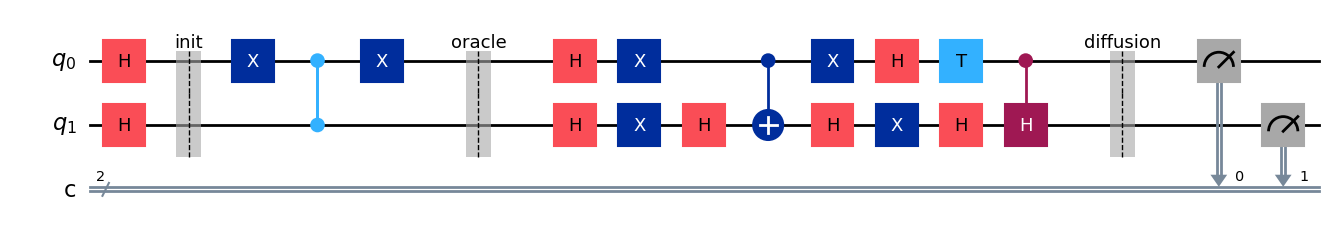

In [15]:
# Inizializza un circuito con 2 qubit e 2 bit classici
qc = QuantumCircuit(2, 2)

# 1. Sovrapposizione: Hadamard su entrambi i qubit
qc.h(range(2))
qc.barrier(label='init')

# 2. Oracolo: cerchiamo lo stato |10⟩
qc.x(0)          # inverti bit 0 (LSB)
qc.cz(0, 1)      # CZ su bit 0 e 1
qc.x(0)          # reinverti bit 0, da commentare per ottenere 11
qc.barrier(label='oracle')

# 3. Diffusione (inversione rispetto alla media)
qc.h([0, 1])
qc.x([0, 1])
qc.h(1)
qc.cx(0, 1)
qc.h(1)
qc.x([0, 1])
qc.h([0, 1])
qc.t(0)
qc.ch(0,1)
qc.barrier(label='diffusion')

state = Statevector.from_instruction(qc)
print(np.round(np.real(state)))

qc.measure([0, 1], [0, 1])
qc.draw('mpl')

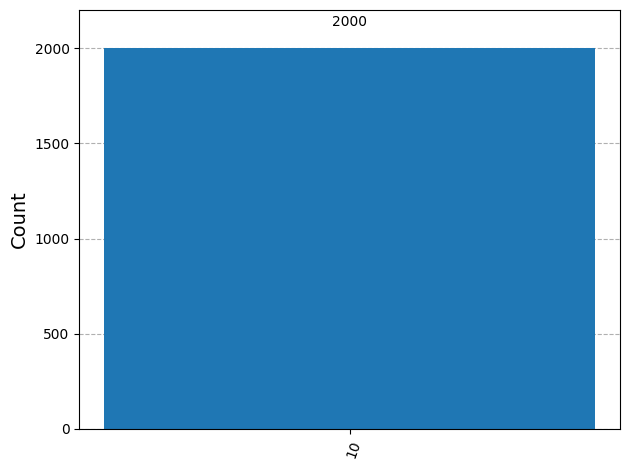

In [16]:
counts = run(qc, 2000)
plot_histogram(counts)

## **Entanglement**

Facendo interagire in maniera opportuna due qubit (due particelle), è possibile metterli in una condizione di **correlazione**, meglio nota come ***entanglement***. Conoscere lo stato di una, significa conoscere lo stato dell'altra, perché queste sono correlate. 

### **Entanglement simmetrico**

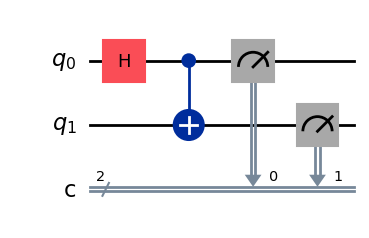

In [17]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)
qc.measure(range(2), range(2))
qc.draw('mpl')

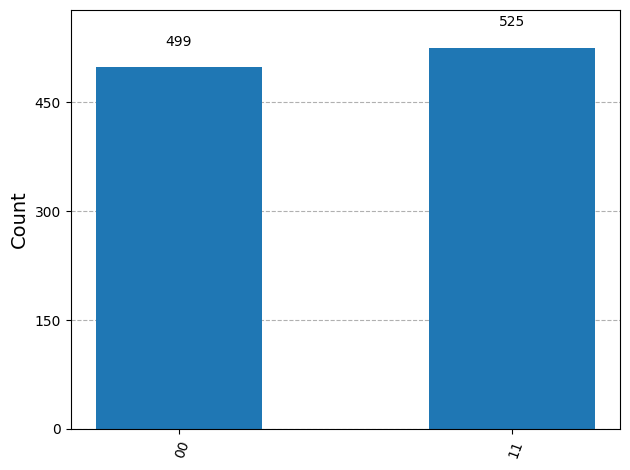

In [18]:
counts = run(qc)
plot_histogram(counts)

### **Entanglement antisimmetrico**

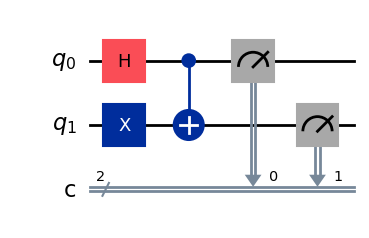

In [19]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.x(1)
qc.cx(0,1)
qc.measure(range(2), range(2))
qc.draw('mpl')

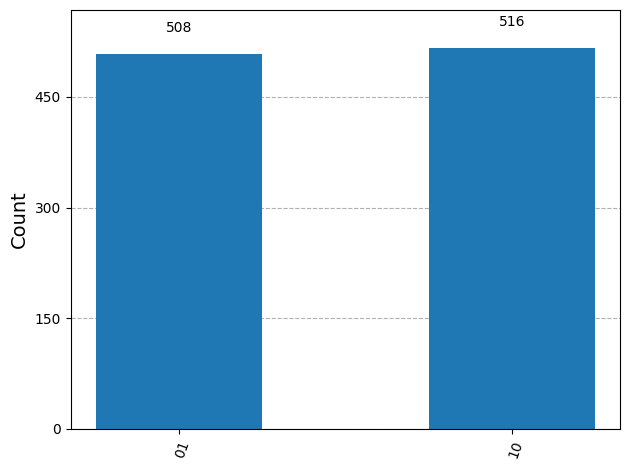

In [20]:
counts = run(qc)
plot_histogram(counts)

## Esercizio 3: **Come sfruttiamo l'entanglement?** - *Superdense Coding*

Esiste un protocollo di comunicazione quantistica capace di codificare due bit di informazione in un singolo qubit di una coppia in entanglement. 

> *Charlie fornisce ad Alice ($q_1$) e a Bob ($q_0$) una coppia di fotoni (qubit) in entanglement.*
>
> *Alice effettua delle trasformazioni esclusivamente sul proprio qubit, e lo manda a Bob.*
>
> *Bob riceve il qubit e lo legge assieme al proprio.*

Alice riesce a comunicare in maniera univoca una stringa di due bit, interagendo solo con uno dei qubit.

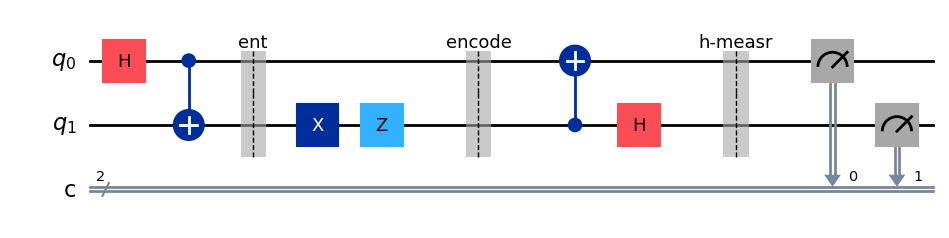

In [21]:
qc = QuantumCircuit(2,2)

bit_0 = 1 # bit da comunicare - bit meno significativo
bit_1 = 1 # bit da comunicare - bit più significativo

# entanglement (Charlie - il provider)
qc.h(0)
qc.cx(0,1)
qc.barrier(label="ent")

# codifica (Alice - il mittente)
if bit_0:
    qc.x(1)
if bit_1:
    qc.z(1)
qc.barrier(label="encode")

# decodifica (Bob - il destinatario)
qc.cx(1,0)
qc.h(1)
qc.barrier(label="h-measr")


qc.measure(range(2),range(2)) # decodifica
qc.draw('mpl')


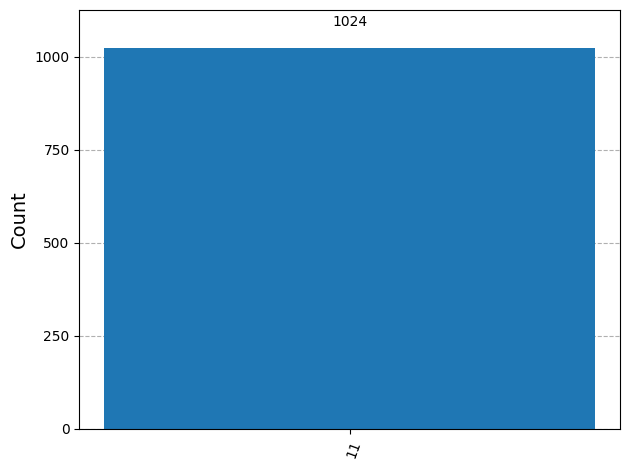

In [22]:
counts = run(qc, 1024)
plot_histogram(counts)

## Esercizio 4: **Stati GHZ** - *Entanglement a più qubit!*

Crea un circuito quantistico che ritorni sempre $|000\rangle$ o $|111\rangle$.

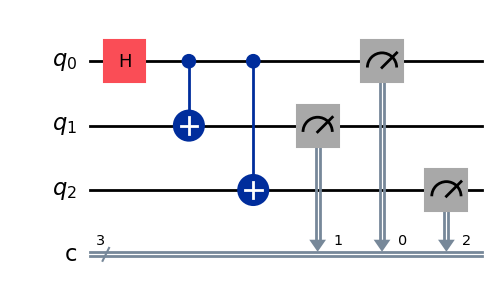

In [23]:
qc = QuantumCircuit(3,3)
qc.h(0)
qc.cx(0, range(1,3))
qc.measure(range(3),range(3))
qc.draw('mpl')

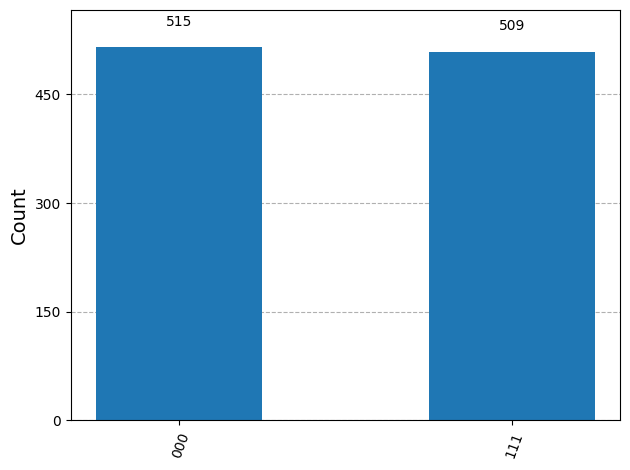

In [24]:
# usa questa cella per verificare i risultati
counts = run(qc, 1024)
plot_histogram(counts)

### Esercizio 4.1:

Crea un circuito quantistico che ritorni sempre $|010\rangle$ o $|101\rangle$.

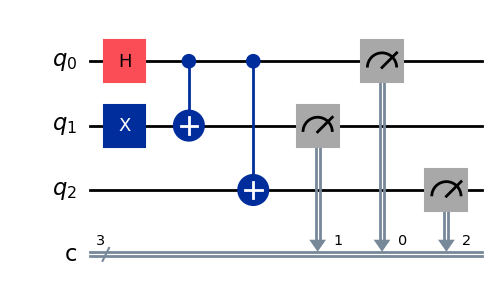

In [25]:
qc = QuantumCircuit(3,3)
qc.h(0)
qc.x(1)
qc.cx(0, range(1,3))
qc.measure(range(3),range(3))
qc.draw('mpl')

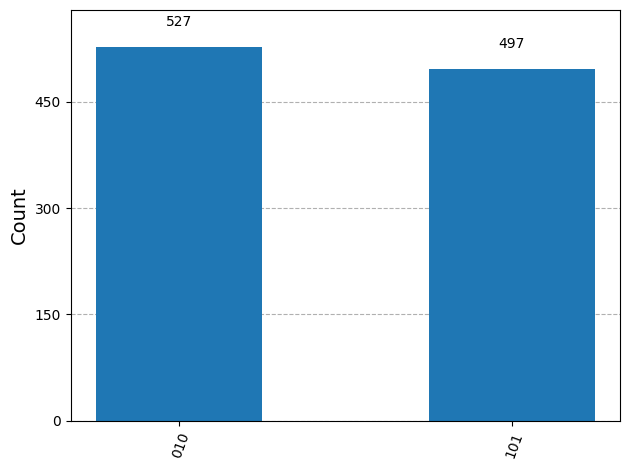

In [26]:
# usa questa cella per verificare i risultati
counts = run(qc, 1024)
plot_histogram(counts)

### Esercizio 4.2:

Crea una funzione che genera un circuito quantistico che torna sempre $|00\dots 0\rangle$ o $|11\dots 1\rangle$.

In [27]:
def generalized_ghz(n: int):
    qc = QuantumCircuit(n, n)
    qc.h(0)
    qc.cx(range(n-1),range(1,n))
    qc.measure(range(n),range(n))
    return qc

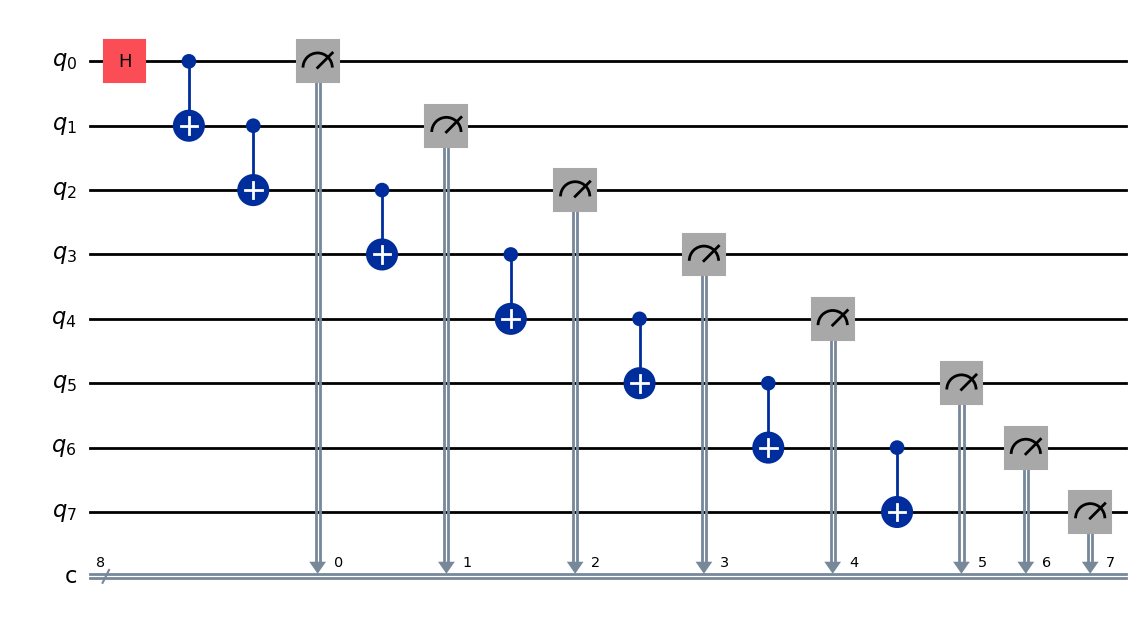

In [28]:
qc = generalized_ghz(8)
qc.draw('mpl')

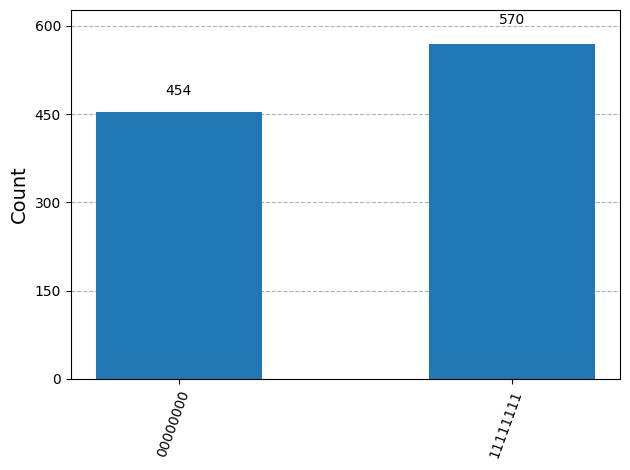

In [29]:
counts = run(qc)
plot_histogram(counts)

## Esercizio 5: **Sperimentiamo!**

Usa questa cella di codice per sperimentare con Qiskit, e crea qualche circuito seguendo gli esercizi svolti in precedenza!

In [30]:
qc = QuantumCircuit(1,1)

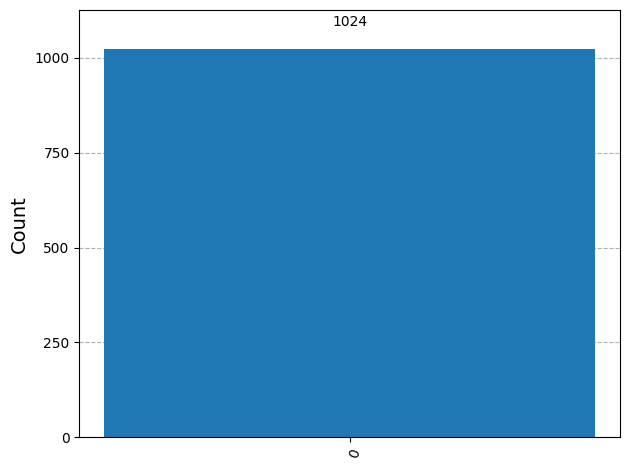

In [31]:
counts = run(qc, 1024)
plot_histogram(counts)